Лабораторная работа №3. Многоклассовый классификатор
Цельработы: В рамках данной работы предполагается исследовать на языке Python методы настройки параметров и гиперпараметров нейронных сетей с помощью разных оптимизаторов, перебора архитектур для решения задач многоклассовой классификации. 

Задание: Выберите предметную область. Скачайте датасет из https://archive.ics.uci.edu//ml/datasets. Необходимо исследовать на языке Python методы настройки параметров и гиперпараметров нейронных сетей с помощью разных оптимизаторов, перебора архитектур для решения задач многоклассовой классификации. Результаты работы привести в отчете. 

Классификация типов автомобилей.

In [17]:
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow

1) Импорт необходимых библиотек:
numpy и pandas: для работы с данными и их манипуляции.
matplotlib.pyplot: для визуализации графиков, таких как потери и точность обучения.
keras: для создания и обучения нейронных сетей.
sklearn: для разделения данных на обучающую и тестовую выборку, а также для расчета метрик классификации, таких как точность, AUC и построение матрицы ошибок.

In [18]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

2) Функция compute_evaluation_metric:

Эта функция выполняет вычисление нескольких ключевых метрик, которые используются для оценки качества модели.

Точность (accuracy): рассчитывается с помощью функции accuracy_score, которая показывает, какой процент объектов был классифицирован правильно.

AUC (Area Under Curve): метрика, отражающая качество модели для многоклассовой классификации, вычисляется с использованием roc_auc_score. Параметр multi_class='ovr' для многоклассового случая.

Матрица ошибок (confusion matrix): позволяет визуализировать, какие классы модель предсказывала правильно, а где были ошибки.

Отчет о классификации (classification report): выводит расширенный отчет о точности, полноте и F1-мере для каждого класса.

In [19]:
# Функция для вычисления метрик
def compute_evaluation_metric(y_test, y_predicted, y_predicted_prob, target_names):
    # Вычисление точности
    accuracy = accuracy_score(y_test, y_predicted)  
    # Вычисление AUC (площадь под кривой)
    auc = roc_auc_score(y_test, y_predicted_prob, multi_class='ovr')  
    # Создание матрицы ошибок
    conf_matrix = confusion_matrix(y_test, y_predicted)  
    # Создание отчета о классификации
    class_report = classification_report(y_test, y_predicted, target_names=target_names)  
    
    return accuracy, auc, conf_matrix, class_report

3) Загрузка данных:
https://archive.ics.uci.edu/dataset/19/car+evaluation
Загружаем датасет, содержащий информацию о характеристиках автомобилей и их классификации. Файл загружается с помощью библиотеки pandas, после чего просматриваем первые несколько строк данных.

Названия колонок включают такие параметры, как цена (buying), затраты на обслуживание (maint), количество дверей (doors), вместимость (persons), размер багажника (lug_boot), уровень безопасности (safety) и класс автомобиля (class).

In [20]:
# Загрузка данных из CSV файла
file_path = "/kaggle/input/carsdata/car.data"
columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']  # Названия колонок
data = pd.read_csv(file_path, names=columns)  # Чтение данных
print(data.head())  # Печать первых нескольких строк данных

  buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc


4) Кодирование категориальных признаков:

Т.к. датасет содержит категориальные признаки (например, цена, количество дверей),необходимо их преобразовать в числовой формат для корректной работы алгоритмов машинного обучения. Для этого используется класс LabelEncoder из библиотеки sklearn.

Для каждой колонки создается собственный энкодер, который преобразует текстовые категории в числовые значения.
Это позволяет легко интерпретировать данные и использовать их для построения модели нейронной сети.

In [21]:
# Преобразование категориальных признаков в числовые
label_encoders = {}
for column in columns:
    label_encoders[column] = LabelEncoder()  # Создание объекта LabelEncoder для каждой колонки
    data[column] = label_encoders[column].fit_transform(data[column])  # Преобразование категориальных значений в числовые


5) Разделение данных на признаки и целевую переменную:

Данные делятся на признаки (X) и целевую переменную (y), где:
X — это все колонки, кроме целевого признака "class".
y — целевая переменная, которую мы будем предсказывать.
Разделение на обучающую и тестовую выборку:

С помощью функции train_test_split данные делятся на обучающую (80%) и тестовую выборку (20%).

Метки классов преобразуются в формат категорий с помощью функции to_categorical, чтобы модель могла корректно работать с многоклассовыми метками.
One-Hot Encoding преобразует целевые метки в двоичный формат, где каждому классу соответствует отдельная позиция с 1 или 0.

In [22]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = data.drop('class', axis=1)  # Все колонки, кроме 'class'
y = data['class']  # Целевая переменная

# Разделение данных на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразование меток классов в формат категорий (one-hot encoding)
Y_train = to_categorical(y_train)  # Обучающая выборка
Y_test = to_categorical(y_test)  # Тестовая выборка

6) Мы выбрали следующие гиперпараметры для обучения:

Оптимизаторы: adam, sgd, rmsprop.
Количество нейронов: 8, 16, 32.
Эпохи: 50.
Размер батча: 32.

In [23]:

# Определение гиперпараметров для обучения модели
optimizers = ['adam', 'sgd', 'rmsprop']  # Оптимизаторы
neurons_options = [8, 16, 32]  # Разное количество нейронов в скрытых слоях
epochs = 50  # Количество эпох обучения
batch_size = 32  # Размер батча

results = {}  # Словарь для хранения результатов
target_names = label_encoders['class'].classes_  # Названия классов

7) Обучение моделей
Обучаем несколько моделей, варьируя гиперпараметры, включая различные оптимизаторы и количество нейронов в скрытых слоях. Для каждой комбинации гиперпараметров мы:

Создаем модель с входным слоем, скрытым слоем, и выходным слоем с активацией softmax для многоклассовой классификации.
Компилируем модель с использованием функции потерь categorical_crossentropy и одного из оптимизаторов.
Обучаем модель на тренировочных данных с валидацией, используя 20% данных для проверки.
Оцениваем модель на тестовых данных и выводим метрики: точность, AUC, матрицу ошибок и отчет о классификации.
Визуализируем графики потерь и точности обучения и валидации по эпохам.

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Optimizer: adam, Neurons: 8, Test loss: 0.6108, Test accuracy: 0.7110

Accuracy Score: 0.7109826589595376
AUC Score: 0.869347578204245

Confusion Matrix:
 [[ 27   0  56   0]
 [  8   0   3   0]
 [ 16   0 219   0]
 [ 15   1   1   0]]

Classification Report:
               precision    recall  f1-score   support

         acc       0.41      0.33      0.36        83
        good       0.00      0.00      0.00        11
       unacc       0.78      0.93      0.85       235
       vgood       0.00      0.00      0.00        17

    accuracy                           0.71       346
   macro avg       0.30      0.31      0.30       346
weighted avg       0.63      0.71      0.67       346



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


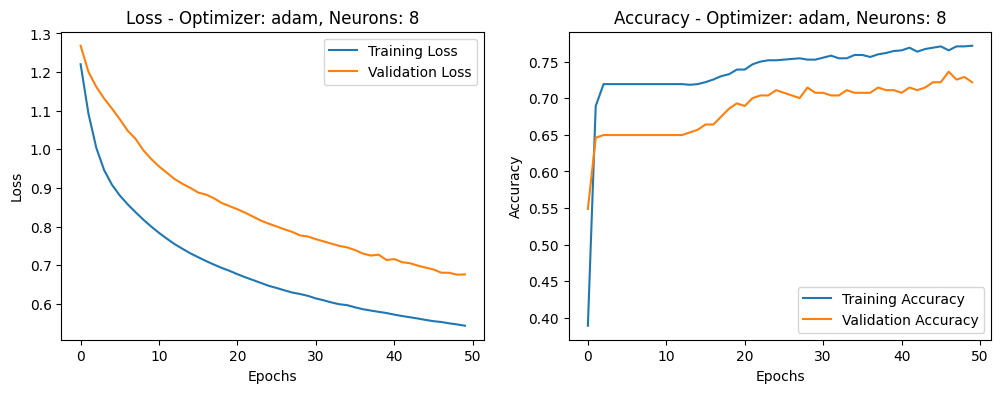

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Optimizer: adam, Neurons: 16, Test loss: 0.4314, Test accuracy: 0.7601

Accuracy Score: 0.7601156069364162
AUC Score: 0.9442607823587521

Confusion Matrix:
 [[ 35   0  48   0]
 [ 10   1   0   0]
 [ 10   0 225   0]
 [ 15   0   0   2]]

Classification Report:
               precision    recall  f1-score   support

         acc       0.50      0.42      0.46        83
        good       1.00      0.09      0.17        11
       unacc       0.82      0.96      0.89       235
       vgood       1.00      0.12      0.21        17

    accuracy                           0.76       346
   macro avg       0.83      0.40      0.43       346
weighted avg       0.76      0.76      0.73       346



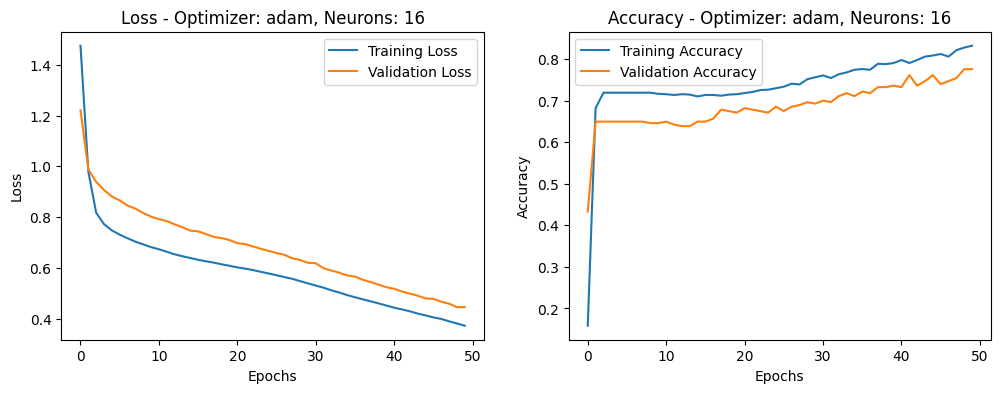

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Optimizer: adam, Neurons: 32, Test loss: 0.2350, Test accuracy: 0.9104

Accuracy Score: 0.9104046242774566
AUC Score: 0.9863548424451982

Confusion Matrix:
 [[ 68   3  12   0]
 [  4   7   0   0]
 [  3   0 232   0]
 [  8   1   0   8]]

Classification Report:
               precision    recall  f1-score   support

         acc       0.82      0.82      0.82        83
        good       0.64      0.64      0.64        11
       unacc       0.95      0.99      0.97       235
       vgood       1.00      0.47      0.64        17

    accuracy                           0.91       346
   macro avg       0.85      0.73      0.77       346
weighted avg       0.91      0.91      0.91       346



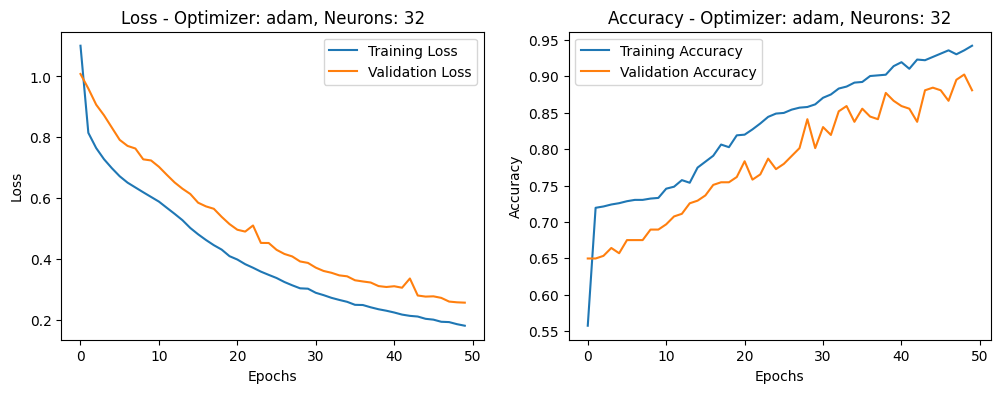

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Optimizer: sgd, Neurons: 8, Test loss: 0.7340, Test accuracy: 0.6705

Accuracy Score: 0.6705202312138728
AUC Score: 0.7612118205950613

Confusion Matrix:
 [[ 12   0  71   0]
 [  1   0  10   0]
 [ 15   0 220   0]
 [ 11   0   6   0]]

Classification Report:
               precision    recall  f1-score   support

         acc       0.31      0.14      0.20        83
        good       0.00      0.00      0.00        11
       unacc       0.72      0.94      0.81       235
       vgood       0.00      0.00      0.00        17

    accuracy                           0.67       346
   macro avg       0.26      0.27      0.25       346
weighted avg       0.56      0.67      0.60       346



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


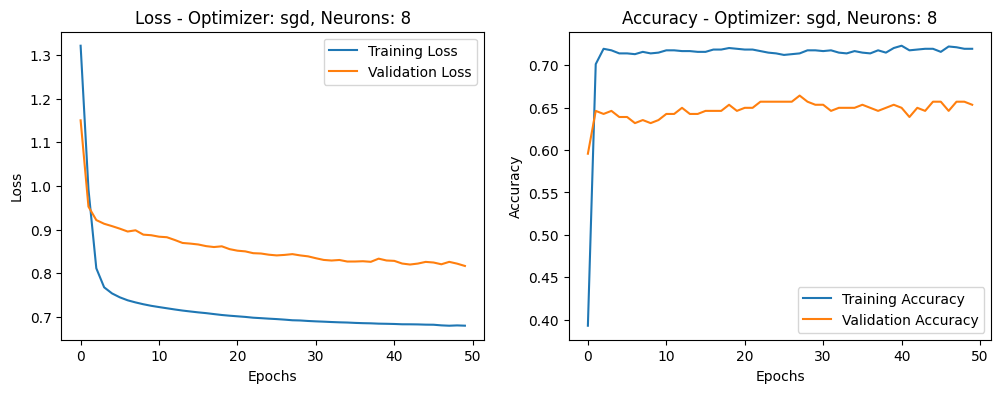

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Optimizer: sgd, Neurons: 16, Test loss: 0.7068, Test accuracy: 0.6821

Accuracy Score: 0.6820809248554913
AUC Score: 0.8066545702917951

Confusion Matrix:
 [[ 18   0  65   0]
 [  5   0   6   0]
 [ 17   0 218   0]
 [ 12   0   5   0]]

Classification Report:
               precision    recall  f1-score   support

         acc       0.35      0.22      0.27        83
        good       0.00      0.00      0.00        11
       unacc       0.74      0.93      0.82       235
       vgood       0.00      0.00      0.00        17

    accuracy                           0.68       346
   macro avg       0.27      0.29      0.27       346
weighted avg       0.59      0.68      0.62       346



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


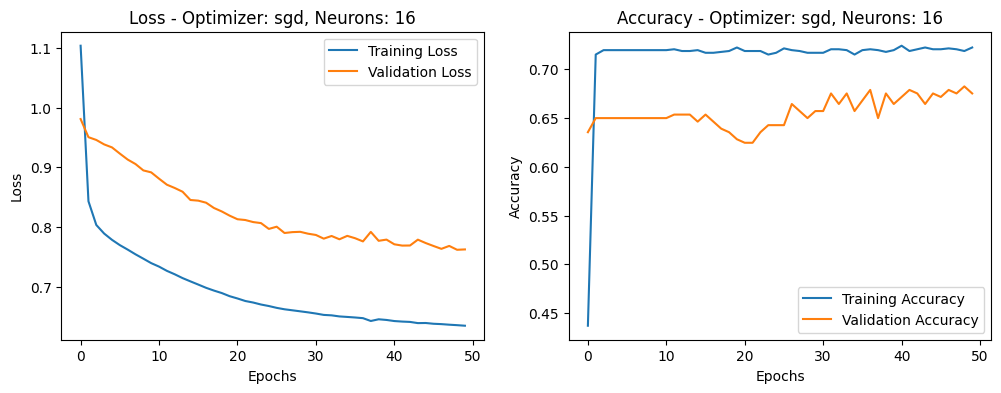

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Optimizer: sgd, Neurons: 32, Test loss: 0.6676, Test accuracy: 0.6879

Accuracy Score: 0.6878612716763006
AUC Score: 0.820202794710254

Confusion Matrix:
 [[ 10   0  73   0]
 [  1   0  10   0]
 [  7   0 228   0]
 [ 12   0   5   0]]

Classification Report:
               precision    recall  f1-score   support

         acc       0.33      0.12      0.18        83
        good       0.00      0.00      0.00        11
       unacc       0.72      0.97      0.83       235
       vgood       0.00      0.00      0.00        17

    accuracy                           0.69       346
   macro avg       0.26      0.27      0.25       346
weighted avg       0.57      0.69      0.60       346



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


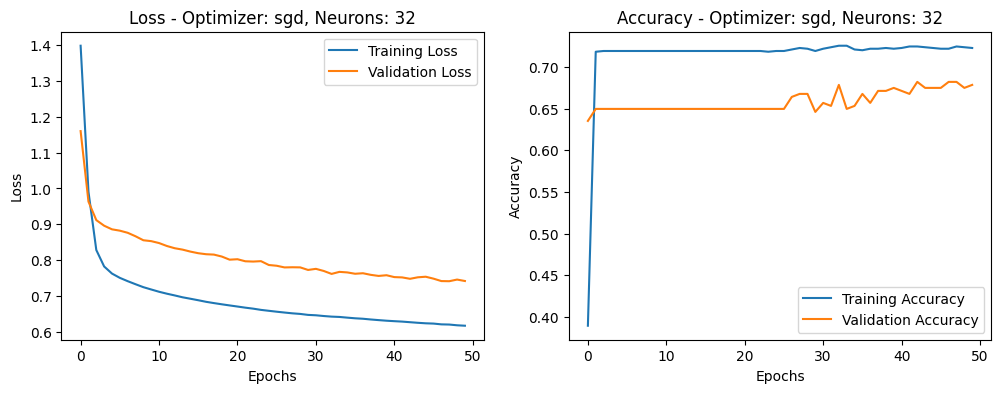

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Optimizer: rmsprop, Neurons: 8, Test loss: 0.5961, Test accuracy: 0.7341

Accuracy Score: 0.7341040462427746
AUC Score: 0.8662343780793925

Confusion Matrix:
 [[ 36   0  47   0]
 [  7   0   4   0]
 [ 17   0 218   0]
 [ 16   0   1   0]]

Classification Report:
               precision    recall  f1-score   support

         acc       0.47      0.43      0.45        83
        good       0.00      0.00      0.00        11
       unacc       0.81      0.93      0.86       235
       vgood       0.00      0.00      0.00        17

    accuracy                           0.73       346
   macro avg       0.32      0.34      0.33       346
weighted avg       0.66      0.73      0.70       346



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


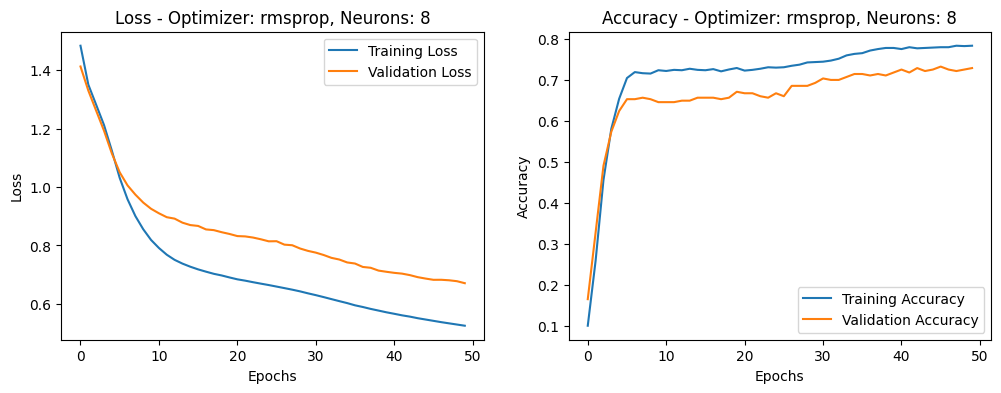

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Optimizer: rmsprop, Neurons: 16, Test loss: 0.5702, Test accuracy: 0.7081

Accuracy Score: 0.708092485549133
AUC Score: 0.8715767067656844

Confusion Matrix:
 [[ 21   0  62   0]
 [  4   0   7   0]
 [ 12   0 223   0]
 [ 14   0   2   1]]

Classification Report:
               precision    recall  f1-score   support

         acc       0.41      0.25      0.31        83
        good       0.00      0.00      0.00        11
       unacc       0.76      0.95      0.84       235
       vgood       1.00      0.06      0.11        17

    accuracy                           0.71       346
   macro avg       0.54      0.32      0.32       346
weighted avg       0.66      0.71      0.65       346



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


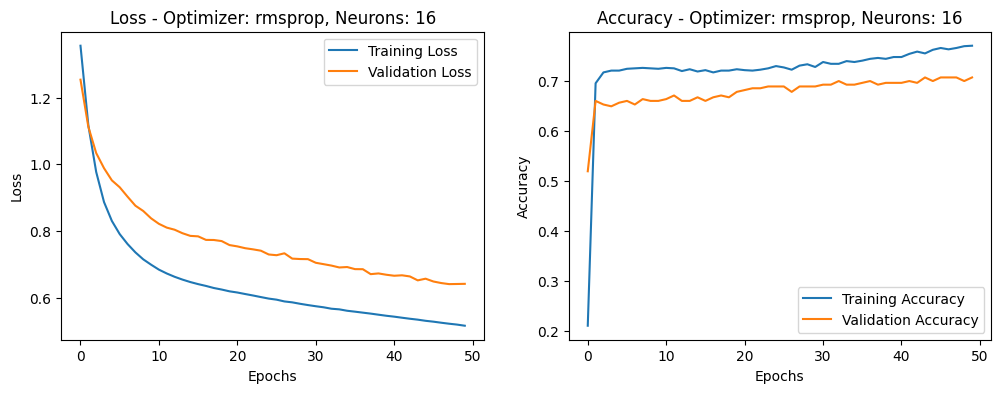

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Optimizer: rmsprop, Neurons: 32, Test loss: 0.3414, Test accuracy: 0.8526

Accuracy Score: 0.8526011560693642
AUC Score: 0.9610569377315916

Confusion Matrix:
 [[ 70   0  13   0]
 [ 11   0   0   0]
 [ 10   0 225   0]
 [ 17   0   0   0]]

Classification Report:
               precision    recall  f1-score   support

         acc       0.65      0.84      0.73        83
        good       0.00      0.00      0.00        11
       unacc       0.95      0.96      0.95       235
       vgood       0.00      0.00      0.00        17

    accuracy                           0.85       346
   macro avg       0.40      0.45      0.42       346
weighted avg       0.80      0.85      0.82       346



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


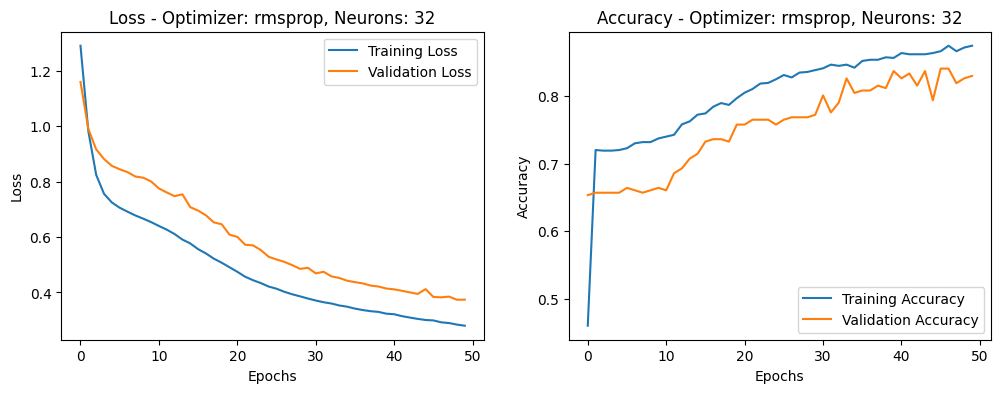

In [24]:
# Обучение моделей с различными гиперпараметрами и вывод результатов
for optimizer in optimizers:
    for neurons in neurons_options:
        # Создание модели
        model = Sequential()  # Инициализация модели
        model.add(Dense(neurons, input_dim=X_train.shape[1], activation="relu"))  # Входной слой
        model.add(Dense(neurons // 2, activation="relu"))  # Скрытый слой
        model.add(Dense(Y_train.shape[1], activation="softmax"))  # Выходной слой с softmax активацией

        # Компиляция модели
        model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

        # Обучение модели
        history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose=0)

        # Оценка модели на тестовых данных
        scores = model.evaluate(X_test, Y_test, verbose=0)
        results[(optimizer, neurons)] = {
            'loss': scores[0],  # Потери на тестовой выборке
            'accuracy': scores[1],  # Точность на тестовой выборке
            'history': history  # История обучения модели
        }

        # Предсказание классов на тестовых данных
        y_pred_prob = model.predict(X_test)  # Вероятности предсказаний
        y_pred = np.argmax(y_pred_prob, axis=1)  # Классы предсказаний

        # Метрики оценки
        accuracy, auc, conf_matrix, class_report = compute_evaluation_metric(
            np.argmax(Y_test, axis=1), y_pred, y_pred_prob, target_names
        )

        # Вывод результатов
        print(f"Optimizer: {optimizer}, Neurons: {neurons}, Test loss: {scores[0]:.4f}, Test accuracy: {scores[1]:.4f}")
        print("\nAccuracy Score:", accuracy)
        print("AUC Score:", auc)
        print("\nConfusion Matrix:\n", conf_matrix)
        print("\nClassification Report:\n", class_report)

        # Построение графиков потерь и точности
        plt.figure(figsize=(12, 4))

        # График потерь
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')  # Потери при обучении
        plt.plot(history.history['val_loss'], label='Validation Loss')  # Потери при валидации
        plt.title(f'Loss - Optimizer: {optimizer}, Neurons: {neurons}')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # График точности
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')  # Точность при обучении
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Точность при валидации
        plt.title(f'Accuracy - Optimizer: {optimizer}, Neurons: {neurons}')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()  # Отображение графиков
